<a href="https://colab.research.google.com/github/Svensone/fast.ai-coursev3/blob/master/lesson3_Segmentation_CAMVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semantic Segmantation with CAMVID Dataset


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
##### subset classes

# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_02040.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009960.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008670.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03210_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08153_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008460_P.png')]

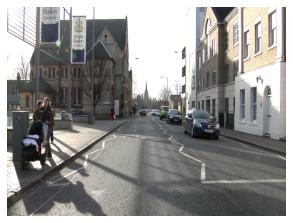

In [7]:
img_1 = fnames[0]
img = open_image(img_1)
img.show(figsize=(5,5))

In [8]:
# get the labels

get_y_fn = lambda x: path_lbl/f"{x.stem}_P{x.suffix}"

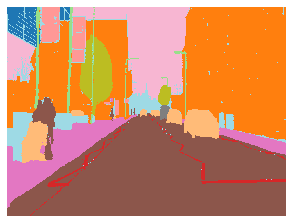

In [10]:
mask = open_mask(get_y_fn(img_1))
mask.show(figsize=(5,5), alpha = 1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 1,  1,  1,  ...,  4,  4,  4],
          [ 1,  1,  1,  ...,  4,  4,  4],
          [ 1,  1,  1,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
size = src_size//2  # integer divide in python '//'

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")


using bs=8, have 11430MB of GPU RAM free


In [17]:
# create DataBunch with DataBlock Api

src = (SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn, classes= codes))


In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))


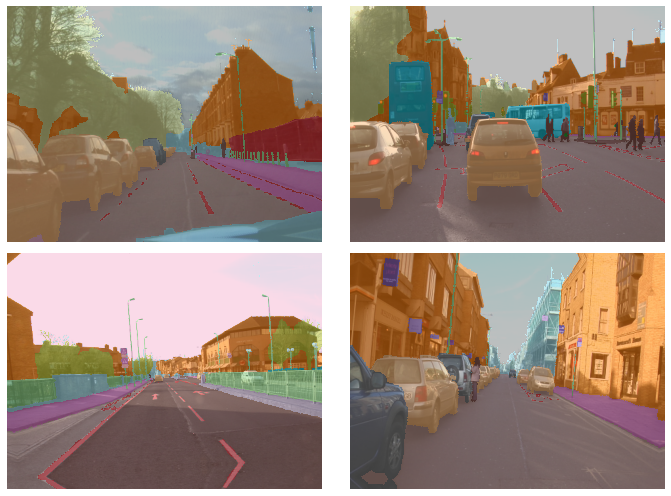

In [19]:
data.show_batch(2, figsize=(10,7))

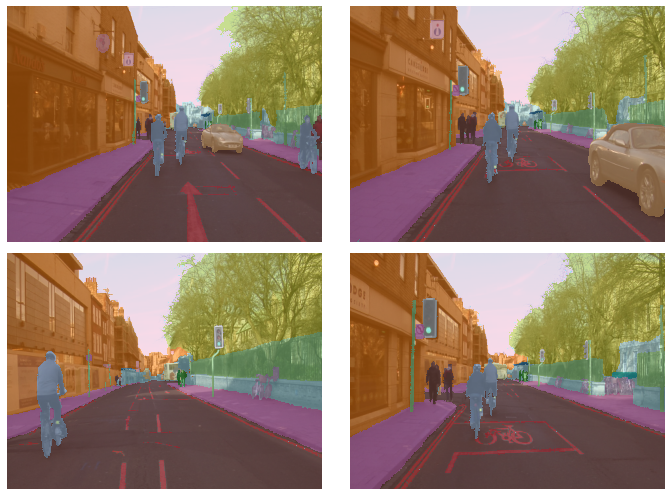

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id["Void"]

# special metric for Segmentation (excluding the "Void" class)
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics = acc_camvid

{'Animal': 0, 'Archway': 1, 'Bicyclist': 2, 'Bridge': 3, 'Building': 4, 'Car': 5, 'CartLuggagePram': 6, 'Child': 7, 'Column_Pole': 8, 'Fence': 9, 'LaneMkgsDriv': 10, 'LaneMkgsNonDriv': 11, 'Misc_Text': 12, 'MotorcycleScooter': 13, 'OtherMoving': 14, 'ParkingBlock': 15, 'Pedestrian': 16, 'Road': 17, 'RoadShoulder': 18, 'Sidewalk': 19, 'SignSymbol': 20, 'Sky': 21, 'SUVPickupTruck': 22, 'TrafficCone': 23, 'TrafficLight': 24, 'Train': 25, 'Tree': 26, 'Truck_Bus': 27, 'Tunnel': 28, 'VegetationMisc': 29, 'Void': 30, 'Wall': 31}


In [22]:
wd = 1e-2 # weight decay

# unet Model (from Uni Freiburg super fast, not only for biomedrical data)
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


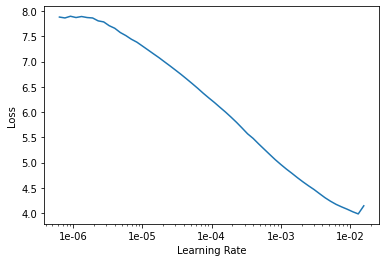

In [23]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 3e-3

learn.fit_one_cycle(10, slice(lr), pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.565760,0.932085,0.775027,03:20
1,0.980356,0.715081,0.815931,03:14
2,0.750433,0.600016,0.833959,03:14
3,0.672227,0.507924,0.866341,03:14
4,0.672984,0.505532,0.860966,03:13
5,0.612631,0.459428,0.876475,03:12
6,0.575266,0.571629,0.853353,03:12
7,0.538367,0.474714,0.862804,03:11
8,0.525626,0.428085,0.886933,03:11
9,0.450284,0.339681,0.892321,03:11


In [24]:
learn.save('stage-1')

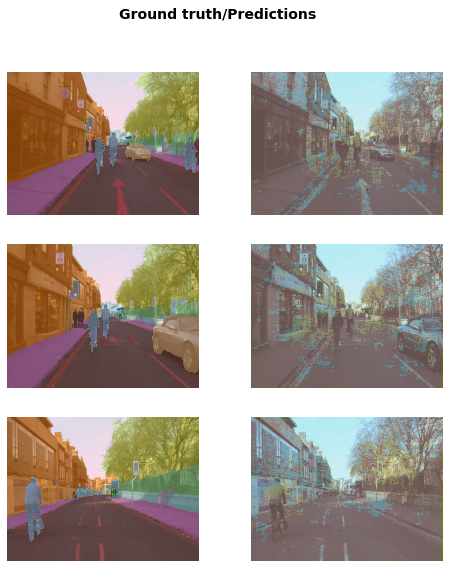

In [26]:
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [27]:
# fine tune

learn.unfreeze()

lrs = slice(lr/400, lr/4)

learn.fit_one_cycle(12, lrs, pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.361155,1.485440,0.635691,03:24
1,1.256271,0.780377,0.810651,03:23
2,0.857367,0.778975,0.792146,03:23
3,0.680609,0.613529,0.841628,03:22
4,0.619796,0.530891,0.856318,03:22
5,0.549129,0.471270,0.865364,03:22
6,0.508835,0.462830,0.876172,03:22
7,0.475081,0.357321,0.900030,03:22
8,0.436979,0.348474,0.899168,03:22
9,0.426163,0.375045,0.893792,03:22


In [ ]:
learn.save('stage-2')

## Go Big

train learner with full image size


In [ ]:
learn.destroy()


size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [27]:
learn.load('stage-2');

In [27]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=1e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [27]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

learn.fit_one_cycle(10, lrs)
learn.save('stage-2-big')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.292209,0.273447,0.921517,03:22
1,0.295697,0.286586,0.918920,03:22
2,0.297853,0.299585,0.913439,03:22
3,0.293799,0.280757,0.920931,03:22
4,0.279768,0.284377,0.918963,03:22
5,0.265004,0.289440,0.917378,03:22
6,0.245964,0.266918,0.922949,03:22
7,0.233743,0.274412,0.921977,03:22


In [ ]:
learn.load('stage-2-big');
learn.show_results(rows=3, figsize=(10,10))